In [59]:
import sklearn as sk
import numpy as np
import pandas as pd
import warnings
import time
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import model_selection
from sklearn import cross_validation
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
warnings.simplefilter('ignore', DeprecationWarning)


class Scorecard():
    def __init__(self, max_bins=8, minimum_leaf=0.025, corr_threshold=0.8, odds_X_to_one = 100, odds_score=700, double_odds=25):        
        self.regressor=LogisticRegression() #Regression build method
        self.x = pd.DataFrame() #Input sample
        self.y = pd.DataFrame() #Targets
        self.vars = []
        self.vars_after_iv_cut = []
        self.vars_after_corr_cut = []
        self.var_list_types = {} #Types of variables
        self.var_list_bins = {} #Binning of scorecard variables dictionary
        self.scorecard = pd.DataFrame() #Final scorecard representation
        self.iv_table = {} #information value tables for each variable
        self.gini = int #Gini of model 
        self.logit_model = [] #model object for LogisticRegression
        self.max_bins = max_bins #Regularization parameter. Maximum bins used in decision tree
        self.minimum_leaf = minimum_leaf #Regularization parameter. Mininmum size of one leaf
        self.column = ''
        self.iv_table = {} #Dictionary which contains iv table for each variable
        self.x_one_hot = pd.DataFrame() #Input sample in one-hot view
        self.corr_threshold = corr_threshold
        self.odds_X_to_one = odds_X_to_one 
        self.odds_score = odds_score
        self.double_odds = double_odds
        self.x_binned = pd.DataFrame()
        self.x_corr_matrix = []
        
   
  
    #Learn model on sample
    def fit(self,x,y,iv_treshold):        
        self.x = x
        self.y = y
        self.x = self.x.reset_index()
        self.y = self.y.reset_index()
        del self.x["index"]
        del self.y["index"]      
        self.fill_vars_cats()   
        print("Start excluding correlations on main sample")
        self.x_corr_matrix = self.x.corr()
        self.exclude_corr_factors(mode='normal')   
        print("Finish excluding correlations on main sample")
        #print('Binning columns...')
        #fill all values of var_list_bins
        for col in self.x.columns: 
            print(col)
            self.binning(mode_forward='binning',mode_output='normal',column_name=col)  
            #Filling IV table on current variable
            df_t = pd.DataFrame(self.binning(mode_forward='forward',mode_output='normal',column_name=col))
            df_t["y"] = self.y
            #df_t = df_t.rename(index=str, columns = {col:"x"})
            df_iv =pd.DataFrame({'count': df_t.groupby(col)['y'].count(), 
                             'bad_rate': df_t.groupby(col)['y'].mean(),
                             'total_goods': df_t.groupby(col)['y'].count() - df_t.groupby(col)['y'].sum(),
                            'total_bads': df_t.groupby(col)['y'].sum() 
                             }).reset_index()
            df_iv["cumm_bads"] = df_iv['total_bads'].cumsum()
            df_iv["cumm_goods"] = df_iv['total_goods'].cumsum()
            df_iv["cumm_total"] = df_iv['count'].cumsum()
            df_iv["per_bad"] = df_iv["total_bads"]/df_iv["cumm_bads"].max()
            df_iv["per_good"] = df_iv["total_goods"]/df_iv["cumm_goods"].max()
            df_iv["woe"] = np.log((df_iv["per_good"])/(df_iv["per_bad"]+0.000000001))
            iv = (df_iv["per_good"] - df_iv["per_bad"])*np.log((df_iv["per_good"])/(df_iv["per_bad"]+0.000000001))
            df_iv["iv"] = iv.sum()       
            self.iv_table[col] = df_iv
            if df_iv["iv"].mean()>=iv_treshold: self.vars_after_iv_cut.append(col)
        #creating sample in one-hot view
        self.x_one_hot = pd.DataFrame(self.x.index.values)       
        for col in self.vars_after_iv_cut:          
            self.x_one_hot = pd.merge(self.x_one_hot, pd.DataFrame(self.binning(mode_forward='forward',mode_output='one-hot',column_name=col)),left_index=True,right_index=True)
        del self.x_one_hot[self.x_one_hot.columns[0]]
        self.x = self.x[self.vars_after_iv_cut] 
        print('Exclude correlations on one-hot...')
        self.exclude_corr_factors(mode='one-hot')   
        print('Building regression...')
        self.regressor.fit(self.x_one_hot,self.y)
        self.scorecard_view()
        
    def predict_proba(self,x):
        self.x = x        
        self.x = x.reset_index()
        del self.x["index"]
        self.x_binned = pd.DataFrame(self.x.index.values)
        cols_to_delete = set(self.x.columns) - set(self.vars_after_iv_cut)
        for c in cols_to_delete:
            del self.x[c]
        for col in self.x.columns:
            self.x_binned = pd.merge(self.x_binned,pd.DataFrame(self.binning(mode_forward='forward',mode_output='one-hot',column_name = col)),left_index=True,right_index=True)
            #del x_binned[x_binned.columns[0]]
        cols_to_delete = set(self.x_binned.columns) - set(self.scorecard["Variable"])
        for c in cols_to_delete:
            del self.x_binned[c]
        return self.regressor.predict_proba(self.x_binned)[:,1]
        
    def predict_score(self,x):
        y_pred = self.predict_proba(x)
        bias = self.odds_score - self.double_odds*np.log(self.odds_X_to_one)/np.log(2)   
        odds = self.double_odds/np.log(2)         
        return bias+odds*np.log(1/y_pred-1)  
      
    
    def scorecard_view(self):
      #  print('Printing scorecard...')
        self.scorecard=[]
        cols = np.array('Intercept')
        cols = np.append(cols,np.array(self.vars_after_corr_cut))
        vals = np.array(self.regressor.intercept_)
        vals = np.append(vals,np.array(self.regressor.coef_))
        self.scorecard = pd.DataFrame(cols)
        self.scorecard.rename(columns={0: 'Variable'},inplace=True)
        self.scorecard["Regression_coef"] = pd.DataFrame(vals)
        b = self.double_odds/np.log(2)
        a = self.odds_score - b*np.log(self.odds_X_to_one)    
        self.scorecard["Score"] = self.scorecard["Regression_coef"]*b
        self.scorecard["Score"][0] = self.scorecard["Score"][0]+a
        self.scorecard["Score"] = round(self.scorecard["Score"],2)
        
    
    
    #Exclude correlations. Fill vars_after_corr_cut. Exclude correlated columns from x_one_hot
    def exclude_corr_factors(self,mode):
        if mode=='normal': x_corr = self.x_corr_matrix
        if mode=='one-hot': x_corr = self.x_one_hot.corr()
        #Оставляем только колонки - потенциальные кандидаты на исключение (хотя бы одно значение корреляции выше трешхолда)
        col_list=[]    
        for i in range(len(x_corr.columns)):
            #Заменяем диагональные значения на 0    
            x_corr[x_corr.columns[i]][x_corr[x_corr.columns[i]].index.values[i]] = 0
            #Если в колонке найдено, хотя бы одно значение с корреляцией больше трешхолда, добавляем ее в лист
            if max(abs(x_corr[x_corr.columns[i]]))>self.corr_threshold: col_list.append(x_corr.columns[i])
        #Оставляем только те колонки, из которых нужно выбрать которые выкинуть из-за корреляций            
        if mode=='one-hot': x_dev_drop =  self.x_one_hot[col_list]
        if mode=='normal': x_dev_drop = self.x[col_list]
        #Строим корреляционную матрицу из оставшихся
        x_c = x_dev_drop.corr()
        #Пустой список
        corr_list = []
        corr_list.append([])
        exclude_iteration = 0
        var_list = [0,1]
        #Заполняем диагональ нулями
        for i in range(len(x_c.columns)):        
            x_c[x_c.columns[i]][x_c[x_c.columns[i]].index.values[i]] = 0
        while len(var_list)>1&len(x_c)>0:
            for i in range(len(x_c.columns)):        
                x_c[x_c.columns[i]][x_c[x_c.columns[i]].index.values[i]] = 0
            #Если нашли хотя бы одну колонку, которая коррелирует с первой, создаем пару в corr_list и записываем туда первую колонку
            if max(abs(x_c[x_c.columns[0]]))>=self.corr_threshold:     
                corr_list[exclude_iteration].append(x_c.columns[0])
            #Пробегаемся по всем колонкам
                for i in range(len(x_c.columns)):
            #Записываем в пару к первой все коррелирующие с ней колонки
                    if abs(x_c[x_c.columns[0]].iloc[i])>=self.corr_threshold:
                        corr_list[exclude_iteration].append(x_c.columns[i])
                #Выкидываем все колонки, которые коррелируют с первой
                var_list = [x for x in x_c.columns.values if x not in corr_list[exclude_iteration]]
                x_dev_drop = x_dev_drop[var_list]
                x_c = x_dev_drop.corr()
                corr_list.append([])
                exclude_iteration = exclude_iteration+1
                print("Excluding correlations. Iteration = ",exclude_iteration,"Corr list: ", corr_list)
        #После обработки corr_list содержит все списки коррелирующих колонок. Из каждого списка оставляем только одну
        cols_to_drop=[] #Список колонок, которые надо выкинуть
        for i in range(len(corr_list)):
            for j in range(len(corr_list[i])):
                if j!=0: 
                    cols_to_drop.append(corr_list[i][j])
        #Оставляем в исходном списке только колонки не из col_to_drop
        print('cols_to_drop = ',cols_to_drop)
        if mode=='one-hot': exclude_list = [x for x in self.x_one_hot.columns.values if x not in cols_to_drop]
        if mode=='normal': exclude_list = [z for z in self.x.columns.values if z not in cols_to_drop]
        print('exclude list = ',exclude_list)
        if mode=='one-hot': self.x_one_hot = self.x_one_hot[exclude_list]
        if mode=='normal': self.x = self.x[exclude_list]
        self.vars_after_corr_cut = exclude_list
        
    
    #Input - one variable name 
    #Output - optimal binning, builded on decision tree. Maximum number of bins = max_bins
    def split_numeric(self,column_name):  
        x_train_t = np.array(self.x[column_name][self.x[column_name].notnull()]) #Exclude nulls 
        y_train_t = np.array(self.y[self.x[column_name].notnull()])
        y_train_t = y_train_t.reshape(len(y_train_t),)
        x_train_t = x_train_t.reshape(x_train_t.shape[0], 1) #Need for DecisionTreeClassifier
        m_depth = int(np.log2(self.max_bins)) + 1 #Maximum tree depth
        bad_rate = y_train_t.mean()
        start = 1
        cv_scores = []
        cv = 3
        for i in range(start,m_depth): #Loop over all tree depth. CV on the each step
            d_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=i, min_samples_leaf=self.minimum_leaf)
            scores = cross_val_score(d_tree, x_train_t, y_train_t, cv=cv,scoring='roc_auc')   
            cv_scores.append(scores.mean())        
        best = np.argmax(cv_scores) + start #Criterion - maximum GINI on validation set        
        final_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=best, min_samples_leaf=0.025) #Build final tree
        final_tree.fit(x_train_t, y_train_t)
        #Final tree
        opt_bins = final_tree.tree_.threshold[final_tree.tree_.feature >= 0]        
        opt_bins = np.append(opt_bins,max(x_train_t)+1)#Add right border
        opt_bins = np.append(opt_bins,min(x_train_t)-1)#Add left border
        opt_bins = np.sort(opt_bins)    
        return opt_bins #Return optimal binning
    
    #Split categorial variable. Grouping variable for regularization.
    #Input = column name
    #Output : add to var_list_bins binned variable as dictionary
    def split_categorial(self,column_name):
        #One-hot encoding
        self.x[column_name] = self.x[column_name].fillna('MISSING')
        x_cat = pd.get_dummies(self.x[column_name],prefix = self.x[column_name].name)
        y_t = np.array(self.y)
        y_t = y_t.reshape(len(y_t),)
        bad_rate = y_t.mean()
        max_bins = max(self.x[column_name].nunique(),20)
        #Classification by decision tree
        m_depth = max_bins+1
        start = 1
        cv_scores = []
        cv = 3
        for i in range(start,m_depth):
            d_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=i, min_samples_leaf=self.minimum_leaf) 
            scores = cross_val_score(d_tree, x_cat, y_t, cv=cv,scoring='roc_auc') 
            cv_scores.append(scores.mean())
        #    print("Number of bins = ", i,"; GINI = ",2*scores.mean()-1)
        best = np.argmax(cv_scores) + start #Choose maximizing GINI on validation dataset
        #print("Optimal number of bins: ",best, "; GINI = ",2*max(cv_scores)-1)
        final_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=best, min_samples_leaf=0.025) #Build final tree
        final_tree.fit(x_cat, self.y)

        #Get leafes names
        x_l = final_tree.apply(x_cat)
        tmp = pd.DataFrame(self.x[column_name])
        tmp["LEAF"] = x_l

        #Make dictionary with optimal binning
        d = {}
        for leaf in tmp["LEAF"].unique():
            d[leaf]=str(self.x[column_name][tmp["LEAF"]==leaf].unique())   
        tmp["x_num"] = tmp["LEAF"].apply(lambda x: d.get(x))
        return d
   
    #Define variable category - numeric or categorial
    #Input - column name
    #Output - numeric or cat
    def check_type(self,column_name):
        from pandas.api.types import is_string_dtype
        from pandas.api.types import is_numeric_dtype   
        #delete nulls
        tmp_var = self.x[column_name][self.x[column_name].notnull()]
        #If number of uniques<=4 then type = categorial
        if tmp_var.nunique()<=4: return 'cat'
        elif is_numeric_dtype(tmp_var): return 'numeric'
        else: return 'cat'
    
    #Fill variable var_list_cats
    def fill_vars_cats(self):
        from pandas.api.types import is_string_dtype
        from pandas.api.types import is_numeric_dtype 
        for col in self.x[self.x.columns]:
            if self.check_type(col)=='numeric': self.var_list_types[col]='numeric'
            if self.check_type(col)=='cat': 
                self.var_list_types[col]='cat'
                if (self.x[col].nunique()<=4)&(is_numeric_dtype(self.x[col])): self.x[col] = self.x[col].apply(lambda x: 'cat_'+str(x))
                
    
    #Add leading zeros to names
    def zero_pad(self,x):
        if str(x)=='MISSING': return '000'
        if len(str(x))==3: return str('00'+str(x))[:-2]+': '
        if len(str(x))==4: return str('0'+str(x))[:-2]+': '
        if len(str(x))==5: str(x)[:-2]+': '
    
    #Naming for categories by rank
    def make_dict(x):        
        x_dict = x.groupby(0)["val"].min().fillna(0).sort_values().reset_index().rename(index=str, columns={0: "x"})
        x_dict['rownum'] = x_dict['val'].rank(method='first', na_option='top')
        x_dict['rownum'] = x_dict['rownum'].apply(zero_pad)
        x_dict['x_num'] = x_dict["rownum"].map(str)+x_dict["x"].map(str)
        del x_dict['val']
        del x_dict['rownum']
        return x_dict   
    
    #Binning procedure
    #Return binned sample. Has two modes - one-hot and norma;
    #Inputs 
    #      x - sample
    #      y - targets
    #      max_bins - maximum number of bins
    #      optimal_bins - for mode_output = 'normal' or 'one-hot' using as input for feed forward
    #                     for mode_forward='binning' calculating of optimal bins
    #                         mode_forward='forward' calculating outputs using optimals bins as input 
    #
    
    #Need for feed forward categorial variables
    #Take value from dictionary var_list_bins and answer if current value is in list
    #If yes - return list
    
    
    def forward_cat(self,x):
        for i in self.var_list_bins[self.column].keys():
            if str(x) in self.var_list_bins[self.column][i]:
                return str(self.var_list_bins[self.column][i]) 
    
    def binning(self,mode_output,mode_forward,column_name):
        variable_type = self.var_list_types[column_name]
        if (variable_type=='numeric')&(mode_forward=='forward'):         
            #Вспомогательная переменная, хранящая разбиения по непустым значениям
            x_bin_t = pd.cut(self.x[column_name][self.x[column_name].notnull()],bins=self.var_list_bins[column_name])    
            #Вспомогательная переменная, хранящая one-hot по непустым значениям
            x_bin = pd.get_dummies(x_bin_t,prefix=self.x[column_name].name,drop_first=True)
            #Добавляем колонку с пустыми значениями
            x_bin[self.x[column_name].name+'_ISNULL']=0
            x_null = pd.DataFrame(self.x[column_name][self.x[column_name].isnull()])
            for i in x_bin.columns:
                x_null[i]=0
            x_null[self.x[column_name].name+'_ISNULL']=1
            del x_null[self.x[column_name].name]
            #Если нет NULL то колонку с dummy is null удаляем   
            if len(self.x[column_name][self.x[column_name].isnull()])==0:
                del x_null[self.x[column_name].name+'_ISNULL']
                del x_bin[self.x[column_name].name+'_ISNULL']
            #Вспомогательная переменная, которая хранит узкий и широкий вид, включая пустые значения    
            x_pivot = pd.concat([x_bin_t,pd.DataFrame(self.x[column_name][self.x[column_name].isnull()])]).sort_index(axis=0)        
            del x_pivot[self.x[column_name].name]
            #Заполняем пустые значения MISSING
            x_pivot = x_pivot.fillna('MISSING')
            x_pivot['val'] = self.x[column_name]        
            #Добавляем категориям индекс (создается справочник)           
            x_dict = x_pivot.groupby(0)["val"].min().fillna(0).sort_values().reset_index().rename(index=str, columns={0: "x"})
            x_dict['rownum'] = x_dict['val'].rank(method='first', na_option='top')
            x_dict['rownum'] = x_dict['rownum'].apply(self.zero_pad)
            x_dict[column_name] = x_dict["rownum"].map(str)+x_dict["x"].map(str)
            del x_dict['val']
            del x_dict['rownum']
            x_d =  x_dict   
            x_pivot["rownum"] = x_pivot.index.values
            x_pivot = pd.merge(x_pivot,x_d,left_on=0,right_on="x").sort_values(by='rownum').reset_index()[column_name]
            #Джойним значения со справочником, удаляем исходные        
            if mode_output=='one-hot': return pd.concat([x_bin,x_null]).sort_index(axis=0) #Возвращаем в виде on-hot                            
            if mode_output=='normal': return x_pivot #Возвращаем в "длинном и узком" виде               
        if (variable_type=='cat')&(mode_forward=='forward'): 
            ####################INPUT CODE HERE#####################
            if mode_output=='normal': 
                self.column = column_name
                return self.x[column_name].apply(self.forward_cat)
            if mode_output=='one-hot': 
                self.column = column_name
                return pd.get_dummies(self.x[column_name].apply(self.forward_cat), drop_first=True,prefix=self.x[column_name].name)
        if (variable_type=='numeric')&(mode_forward=='binning'):
            self.var_list_bins[column_name] = self.split_numeric(column_name)
        if (variable_type=='cat')&(mode_forward=='binning'):                
            self.var_list_bins[column_name] = self.split_categorial(column_name)
            #x_bin = self.split_categorial(column_name)          
            #if mode_output=='one-hot': return pd.get_dummies(x_bin,prefix=self.x[column_name].name,drop_first=True)
            #if mode_output=='normal': return pd.DataFrame(x_bin)
    
     


In [3]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
start_time = time.time()
df1 = pd.read_csv('./data/MS_CC_EXPORT1.txt', sep=';',index_col=False, decimal=',') 
df2 = pd.read_csv('./data/MS_CC_EXPORT2.txt', sep=';',index_col=False, decimal=',') 
df3 = pd.read_csv('./data/MS_CC_EXPORT3.txt', sep=';',index_col=False, decimal=',') 
df4 = pd.read_csv('./data/MS_CC_EXPORT4.txt', sep=';',index_col=False, decimal=',') 
print(-start_time + time.time(),"sec")

74.54057812690735 sec


In [4]:
df = pd.concat([df1,df2,df3,df4])

In [5]:
columns = ["UCI",
"TR_PROFIT",
"TOTAL_COUNT_DEL1_30_M1000_SUM",
"TOTAL_COUNT_DEL_M1000_SUM",
"TB",
"TARGET3Y_1000_DEBTOR",
"SRV_SBOL_WEB_3M_LOGIN_NFLAG",
"SRV_SBOL_WEB_1M_LOGIN_NFLAG",
"SRV_SBOL_TXN_WEB_3M_AMT",
"SRV_SBOL_TXN_WEB_1M_AMT",
"SRV_MB_TOT_QTY",
"SRV_AP_UTL_QTY",
"SEGMENT",
"SD_AGE_YRS_FRAC_NV",
"RUR_SAS_6MONTHS",
"RATE_TR_PAY_L3_6M",
"RATE_TR_PAY_L1_6M",
"RATE_TR_PAY_L1_3M",
"RATE_TR_CARD_TRANS_L3_6M",
"RATE_TR_ALL_L3_6M",
"RATE_TR_ALL_L1_3M",
"RATE_TR_ALL_7D_6M",
"RATE_TR_ALL_7D_3M",
"NON_DEL_LIFETIME_SUM",
"MONTHS_FRM_FIRST_AGR_OPEN_SBRF",
"MIN_TERM_REQUEST_CLOSED_AGR",
"MIN_APP_DAYS",
"MAX_TR_RECEIPT_3M_RUR",
"MAX_PROF",
"MAX_MATURITY",
"MAX_DELINQ_OPEN_AGR",
"MAX_ARREAR",
"LBT_SOCIAL_L3M_AVG_RUB_AMT",
"LBT_PAYROLL_L6M_TOT_RUB_AMT",
"LBT_ACCT_TOT_BAL_PREV_RUB001",
"LBT_ACCT_TOT_BAL_PREV_RUB_AMT",
"LBT_ACCT_DEP_TOT_BAL_RUB_AMT",
"LBT_ACCT_DEP_TD_BAL_RUB_AMT",
"LBT_ACCT_DEP_MNTH_LST_CLSR_QTY",
"LBT_ACCT_DEP_CA_BAL_RUB_AMT",
"LAST_OPENED",
"LAST_DEL_DAYS_PRC_MAX",
"FIRST_OPENED",
"DEP_TOPUP_12M_AVG_RUB_AMT",
"DCI",
"CRD_TRX_DC_POS_RTRN_6M_QTY",
"CRD_TRX_DC_CASH_3M_QTY",
"CRD_POS_TOURISM_RUB_3M_AMT",
"CRD_POS_CLOTHES_RUB_3M_AMT",
"CRD_POS_CLOTHES_3M_QTY",
"CRD_POS_AUTO_RUB_3M_AMT",
"CRD_OTF_TRNF_ORG_RUB_AMT",
"CRD_OTF_TRNF_ORG_QTY",
"CRD_OTF_FEE_QTY",
"CRD_OTF_DC_TOTAL_QTY",
"CRD_OTF_DC_CASH_QTY",
"CRD_DC_SOCIAL_PMT_NFLAG",
"CRD_DC_POS_HOME_REPAIR_QTY",
"CRD_DC_POS_HEALTHC_RUB_AMT",
"CRD_DC_POS_CLOTHES_QTY",
"CRD_DC_PAYROLL_PMT_NFLAG",
"CRD_DC_MNTH_SNC_OPEN_QTY",
"CRD_CC_EVER_NFLAG",
"CNT_TR_REPAIR_6M",
"CNT_TR_RELAX_6M",
"CNT_TR_PUBL_UTIL_6M",
"CNT_TR_PUBL_UTIL_3M",
"CNT_TR_PUBL_UTIL_1M",
"CNT_TR_PAY_6M",
"CNT_TR_PAY_3M",
"CNT_TR_PAY_1M",
"CNT_TR_MEDICINE_6M",
"CNT_TR_CASH_6M",
"CNT_TR_CASH_3M",
"CNT_TR_CASH_1M",
"CNT_TR_CARD_TRANS_6M",
"CNT_TR_CARD_TRANS_3M",
"CNT_TR_CARD_TRANS_1M",
"CNT_TR_ALL_7D",
"CNT_TR_ALL_6M",
"CNT_TR_ALL_3M",
"CNT_TR_ALL_1M",
"CNT_OPENED_6M1Y",
"CNT_OPENED_6M",
"CNT_AGREEMENTS_TOTAL",
"CNT_AGR_WO_ARREAR_TO_CNT",
"CNT_AGR_OPEN_LAST3",
"CNT_AGR_OPEN",
"CMPN_TM_AVAIL_NFLAG",
"CMPN_EMAIL_AVAIL_NFLAG",
"CMPN_DM_AVAIL_NFLAG",
"AVG_TERM_FACT",
"ARREARS_CROSS",
"AGR_DATE",
"FLG_MOB12_90",
"SCORE_FINAL"
]

In [6]:
dates = [ "JAN-17", 
 "FEB-17", 
 "MAR-17", 
 "APR-17", 
 "MAY-17", 
 "JUN-17", 
 "JUL-17", 
 "AUG-17", 
 "SEP-17", 
 "OCT-17", 
 "NOV-17", 
 "DEC-17" 
]

In [7]:
df_train = df[(df["AGR_DATE"]=="JAN-17")|(df["AGR_DATE"]=="FEB-17")|(df["AGR_DATE"]=="MAR-17")|(df["AGR_DATE"]=="APR-17")]
df_test = df[(df["AGR_DATE"]=="MAY-17")|(df["AGR_DATE"]=="JUN-17")|(df["AGR_DATE"]=="JUL-17")]


In [87]:
x_train = pd.DataFrame(df_train[columns].copy())
x_train1 = x_train[x_train["SEGMENT"]==1]
x_train2 = x_train[x_train["SEGMENT"]==2]
x_train3 = x_train[x_train["SEGMENT"]==3]
x_train4 = x_train[x_train["SEGMENT"]==4]
x_test = pd.DataFrame(df_test[columns].copy())
x_test1 = x_test[x_test["SEGMENT"]==1]
x_test2 = x_test[x_test["SEGMENT"]==2]
x_test3 = x_test[x_test["SEGMENT"]==3]
x_test4 = x_test[x_test["SEGMENT"]==4]
x_train = x_train[x_train['FLG_MOB12_90'].notnull()]
x_train1 = x_train1[x_train1['FLG_MOB12_90'].notnull()]
x_train2 = x_train2[x_train2['FLG_MOB12_90'].notnull()]
x_train3 = x_train3[x_train3['FLG_MOB12_90'].notnull()]
x_train4 = x_train4[x_train4['FLG_MOB12_90'].notnull()]
x_test1 = x_test1[x_test1['FLG_MOB12_90'].notnull()]
x_test2 = x_test2[x_test2['FLG_MOB12_90'].notnull()]
x_test3 = x_test3[x_test3['FLG_MOB12_90'].notnull()]
x_test4 = x_test4[x_test4['FLG_MOB12_90'].notnull()]
x_test = x_test[x_test['FLG_MOB12_90'].notnull()]
y_train = pd.DataFrame(x_train['FLG_MOB12_90'])
y_train1 = pd.DataFrame(x_train1['FLG_MOB12_90'])
y_train2 = pd.DataFrame(x_train2['FLG_MOB12_90'])
y_train3 = pd.DataFrame(x_train3['FLG_MOB12_90'])
y_train4 = pd.DataFrame(x_train4['FLG_MOB12_90'])
y_test = pd.DataFrame(x_test['FLG_MOB12_90'])
y_test1 = pd.DataFrame(x_test1['FLG_MOB12_90'])
y_test2 = pd.DataFrame(x_test2['FLG_MOB12_90'])
y_test3 = pd.DataFrame(x_test3['FLG_MOB12_90'])
y_test4 = pd.DataFrame(x_test4['FLG_MOB12_90'])
x_train = x_train.drop(['CNT_TR_CASH_1M','LBT_PAYROLL_L6M_TOT_RUB_AMT','RATE_TR_ALL_L3_6M','RATE_TR_ALL_L1_3M','TOTAL_COUNT_DEL1_30_M1000_SUM','RATE_TR_PAY_L1_6M','RATE_TR_ALL_7D_6M','LBT_ACCT_DEP_TOT_BAL_RUB_AMT','LBT_ACCT_DEP_TD_BAL_RUB_AMT','CNT_TR_PUBL_UTIL_1M','CNT_TR_PUBL_UTIL_6M','CNT_TR_CASH_6M','CNT_TR_CASH_6M','CNT_TR_CARD_TRANS_3M','CNT_TR_CARD_TRANS_1M','CNT_AGR_OPEN','FLG_MOB12_90','AGR_DATE','SCORE_FINAL','LBT_ACCT_TOT_BAL_PREV_RUB001','CNT_TR_PAY_3M','CNT_TR_PAY_1M','CNT_TR_ALL_7D','CNT_TR_ALL_6M','CNT_TR_ALL_1M'],axis=1)
x_train1 = x_train1.drop(['CNT_TR_CASH_1M','LBT_PAYROLL_L6M_TOT_RUB_AMT','RATE_TR_ALL_L3_6M','RATE_TR_ALL_L1_3M','TOTAL_COUNT_DEL1_30_M1000_SUM','RATE_TR_PAY_L1_6M','RATE_TR_ALL_7D_6M','LBT_ACCT_DEP_TOT_BAL_RUB_AMT','LBT_ACCT_DEP_TD_BAL_RUB_AMT','CNT_TR_PUBL_UTIL_1M','CNT_TR_PUBL_UTIL_6M','CNT_TR_CASH_6M','CNT_TR_CASH_6M','CNT_TR_CARD_TRANS_3M','CNT_TR_CARD_TRANS_1M','CNT_AGR_OPEN','FLG_MOB12_90','AGR_DATE','SCORE_FINAL','LBT_ACCT_TOT_BAL_PREV_RUB001','CNT_TR_PAY_3M','CNT_TR_PAY_1M','CNT_TR_ALL_7D','CNT_TR_ALL_6M','CNT_TR_ALL_1M'],axis=1)
x_train2 = x_train2.drop(['CNT_TR_CASH_1M','LBT_PAYROLL_L6M_TOT_RUB_AMT','RATE_TR_ALL_L3_6M','RATE_TR_ALL_L1_3M','TOTAL_COUNT_DEL1_30_M1000_SUM','RATE_TR_PAY_L1_6M','RATE_TR_ALL_7D_6M','LBT_ACCT_DEP_TOT_BAL_RUB_AMT','LBT_ACCT_DEP_TD_BAL_RUB_AMT','CNT_TR_PUBL_UTIL_1M','CNT_TR_PUBL_UTIL_6M','CNT_TR_CASH_6M','CNT_TR_CASH_6M','CNT_TR_CARD_TRANS_3M','CNT_TR_CARD_TRANS_1M','CNT_AGR_OPEN','FLG_MOB12_90','AGR_DATE','SCORE_FINAL','LBT_ACCT_TOT_BAL_PREV_RUB001','CNT_TR_PAY_3M','CNT_TR_PAY_1M','CNT_TR_ALL_7D','CNT_TR_ALL_6M','CNT_TR_ALL_1M'],axis=1)
x_train3 = x_train3.drop(['CNT_TR_CASH_1M','LBT_PAYROLL_L6M_TOT_RUB_AMT','RATE_TR_ALL_L3_6M','RATE_TR_ALL_L1_3M','TOTAL_COUNT_DEL1_30_M1000_SUM','RATE_TR_PAY_L1_6M','RATE_TR_ALL_7D_6M','LBT_ACCT_DEP_TOT_BAL_RUB_AMT','LBT_ACCT_DEP_TD_BAL_RUB_AMT','CNT_TR_PUBL_UTIL_1M','CNT_TR_PUBL_UTIL_6M','CNT_TR_CASH_6M','CNT_TR_CASH_6M','CNT_TR_CARD_TRANS_3M','CNT_TR_CARD_TRANS_1M','CNT_AGR_OPEN','FLG_MOB12_90','AGR_DATE','SCORE_FINAL','LBT_ACCT_TOT_BAL_PREV_RUB001','CNT_TR_PAY_3M','CNT_TR_PAY_1M','CNT_TR_ALL_7D','CNT_TR_ALL_6M','CNT_TR_ALL_1M'],axis=1)
x_train4 = x_train4.drop(['CNT_TR_CASH_1M','LBT_PAYROLL_L6M_TOT_RUB_AMT','RATE_TR_ALL_L3_6M','RATE_TR_ALL_L1_3M','TOTAL_COUNT_DEL1_30_M1000_SUM','RATE_TR_PAY_L1_6M','RATE_TR_ALL_7D_6M','LBT_ACCT_DEP_TOT_BAL_RUB_AMT','LBT_ACCT_DEP_TD_BAL_RUB_AMT','CNT_TR_PUBL_UTIL_1M','CNT_TR_PUBL_UTIL_6M','CNT_TR_CASH_6M','CNT_TR_CASH_6M','CNT_TR_CARD_TRANS_3M','CNT_TR_CARD_TRANS_1M','CNT_AGR_OPEN','FLG_MOB12_90','AGR_DATE','SCORE_FINAL','LBT_ACCT_TOT_BAL_PREV_RUB001','CNT_TR_PAY_3M','CNT_TR_PAY_1M','CNT_TR_ALL_7D','CNT_TR_ALL_6M','CNT_TR_ALL_1M'],axis=1)
x_test = x_test.drop(['CNT_TR_CASH_1M','LBT_PAYROLL_L6M_TOT_RUB_AMT','RATE_TR_ALL_L3_6M','RATE_TR_ALL_L1_3M','TOTAL_COUNT_DEL1_30_M1000_SUM','RATE_TR_PAY_L1_6M','RATE_TR_ALL_7D_6M','LBT_ACCT_DEP_TOT_BAL_RUB_AMT','LBT_ACCT_DEP_TD_BAL_RUB_AMT','CNT_TR_PUBL_UTIL_1M','CNT_TR_PUBL_UTIL_6M','CNT_TR_CASH_6M','CNT_TR_CASH_6M','CNT_TR_CARD_TRANS_3M','CNT_TR_CARD_TRANS_1M','CNT_AGR_OPEN','FLG_MOB12_90','AGR_DATE','SCORE_FINAL','LBT_ACCT_TOT_BAL_PREV_RUB001','CNT_TR_PAY_3M','CNT_TR_PAY_1M','CNT_TR_ALL_7D','CNT_TR_ALL_6M','CNT_TR_ALL_1M'],axis=1)
x_test1 = x_test1.drop(['CNT_TR_CASH_1M','LBT_PAYROLL_L6M_TOT_RUB_AMT','RATE_TR_ALL_L3_6M','RATE_TR_ALL_L1_3M','TOTAL_COUNT_DEL1_30_M1000_SUM','RATE_TR_PAY_L1_6M','RATE_TR_ALL_7D_6M','LBT_ACCT_DEP_TOT_BAL_RUB_AMT','LBT_ACCT_DEP_TD_BAL_RUB_AMT','CNT_TR_PUBL_UTIL_1M','CNT_TR_PUBL_UTIL_6M','CNT_TR_CASH_6M','CNT_TR_CASH_6M','CNT_TR_CARD_TRANS_3M','CNT_TR_CARD_TRANS_1M','CNT_AGR_OPEN','FLG_MOB12_90','AGR_DATE','SCORE_FINAL','LBT_ACCT_TOT_BAL_PREV_RUB001','CNT_TR_PAY_3M','CNT_TR_PAY_1M','CNT_TR_ALL_7D','CNT_TR_ALL_6M','CNT_TR_ALL_1M'],axis=1)
x_test2 = x_test2.drop(['CNT_TR_CASH_1M','LBT_PAYROLL_L6M_TOT_RUB_AMT','RATE_TR_ALL_L3_6M','RATE_TR_ALL_L1_3M','TOTAL_COUNT_DEL1_30_M1000_SUM','RATE_TR_PAY_L1_6M','RATE_TR_ALL_7D_6M','LBT_ACCT_DEP_TOT_BAL_RUB_AMT','LBT_ACCT_DEP_TD_BAL_RUB_AMT','CNT_TR_PUBL_UTIL_1M','CNT_TR_PUBL_UTIL_6M','CNT_TR_CASH_6M','CNT_TR_CASH_6M','CNT_TR_CARD_TRANS_3M','CNT_TR_CARD_TRANS_1M','CNT_AGR_OPEN','FLG_MOB12_90','AGR_DATE','SCORE_FINAL','LBT_ACCT_TOT_BAL_PREV_RUB001','CNT_TR_PAY_3M','CNT_TR_PAY_1M','CNT_TR_ALL_7D','CNT_TR_ALL_6M','CNT_TR_ALL_1M'],axis=1)
x_test3 = x_test3.drop(['CNT_TR_CASH_1M','LBT_PAYROLL_L6M_TOT_RUB_AMT','RATE_TR_ALL_L3_6M','RATE_TR_ALL_L1_3M','TOTAL_COUNT_DEL1_30_M1000_SUM','RATE_TR_PAY_L1_6M','RATE_TR_ALL_7D_6M','LBT_ACCT_DEP_TOT_BAL_RUB_AMT','LBT_ACCT_DEP_TD_BAL_RUB_AMT','CNT_TR_PUBL_UTIL_1M','CNT_TR_PUBL_UTIL_6M','CNT_TR_CASH_6M','CNT_TR_CASH_6M','CNT_TR_CARD_TRANS_3M','CNT_TR_CARD_TRANS_1M','CNT_AGR_OPEN','FLG_MOB12_90','AGR_DATE','SCORE_FINAL','LBT_ACCT_TOT_BAL_PREV_RUB001','CNT_TR_PAY_3M','CNT_TR_PAY_1M','CNT_TR_ALL_7D','CNT_TR_ALL_6M','CNT_TR_ALL_1M'],axis=1)
x_test4 = x_test4.drop(['CNT_TR_CASH_1M','LBT_PAYROLL_L6M_TOT_RUB_AMT','RATE_TR_ALL_L3_6M','RATE_TR_ALL_L1_3M','TOTAL_COUNT_DEL1_30_M1000_SUM','RATE_TR_PAY_L1_6M','RATE_TR_ALL_7D_6M','LBT_ACCT_DEP_TOT_BAL_RUB_AMT','LBT_ACCT_DEP_TD_BAL_RUB_AMT','CNT_TR_PUBL_UTIL_1M','CNT_TR_PUBL_UTIL_6M','CNT_TR_CASH_6M','CNT_TR_CASH_6M','CNT_TR_CARD_TRANS_3M','CNT_TR_CARD_TRANS_1M','CNT_AGR_OPEN','FLG_MOB12_90','AGR_DATE','SCORE_FINAL','LBT_ACCT_TOT_BAL_PREV_RUB001','CNT_TR_PAY_3M','CNT_TR_PAY_1M','CNT_TR_ALL_7D','CNT_TR_ALL_6M','CNT_TR_ALL_1M'],axis=1)



In [75]:
x_train.corr().to_csv('./data/corr.csv', sep=';')

In [69]:
pd.DataFrame(x_train.columns).to_csv('./data/columns.csv')

In [88]:
s = Scorecard()
s1 = Scorecard()
s2 = Scorecard()
s3 = Scorecard()
s4 = Scorecard()


In [ ]:
s.fit(x_train,y_train,iv_treshold=0.02)
s1.fit(x_train1,y_train1,iv_treshold=0.02)
s2.fit(x_train2,y_train2,iv_treshold=0.02)
s3.fit(x_train3,y_train3,iv_treshold=0.02)
s4.fit(x_train4,y_train4,iv_treshold=0.02)

Start excluding correlations on main sample
cols_to_drop =  []
exclude list =  ['UCI', 'TR_PROFIT', 'TOTAL_COUNT_DEL_M1000_SUM', 'TB', 'TARGET3Y_1000_DEBTOR', 'SRV_SBOL_WEB_3M_LOGIN_NFLAG', 'SRV_SBOL_WEB_1M_LOGIN_NFLAG', 'SRV_SBOL_TXN_WEB_3M_AMT', 'SRV_SBOL_TXN_WEB_1M_AMT', 'SRV_MB_TOT_QTY', 'SRV_AP_UTL_QTY', 'SEGMENT', 'SD_AGE_YRS_FRAC_NV', 'RUR_SAS_6MONTHS', 'RATE_TR_PAY_L3_6M', 'RATE_TR_PAY_L1_3M', 'RATE_TR_CARD_TRANS_L3_6M', 'RATE_TR_ALL_7D_3M', 'NON_DEL_LIFETIME_SUM', 'MONTHS_FRM_FIRST_AGR_OPEN_SBRF', 'MIN_TERM_REQUEST_CLOSED_AGR', 'MIN_APP_DAYS', 'MAX_TR_RECEIPT_3M_RUR', 'MAX_PROF', 'MAX_MATURITY', 'MAX_DELINQ_OPEN_AGR', 'MAX_ARREAR', 'LBT_SOCIAL_L3M_AVG_RUB_AMT', 'LBT_ACCT_TOT_BAL_PREV_RUB_AMT', 'LBT_ACCT_DEP_MNTH_LST_CLSR_QTY', 'LBT_ACCT_DEP_CA_BAL_RUB_AMT', 'LAST_OPENED', 'LAST_DEL_DAYS_PRC_MAX', 'FIRST_OPENED', 'DEP_TOPUP_12M_AVG_RUB_AMT', 'DCI', 'CRD_TRX_DC_POS_RTRN_6M_QTY', 'CRD_TRX_DC_CASH_3M_QTY', 'CRD_POS_TOURISM_RUB_3M_AMT', 'CRD_POS_CLOTHES_RUB_3M_AMT', 'CRD_POS_CLOTHE

C:\Users\sysoev-mv\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sysoev-mv\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Start excluding correlations on main sample
Excluding correlations. Iteration =  1 Corr list:  [['TR_PROFIT', 'MAX_PROF'], []]
Excluding correlations. Iteration =  2 Corr list:  [['TR_PROFIT', 'MAX_PROF'], ['LAST_OPENED', 'CRD_DC_MNTH_SNC_OPEN_QTY'], []]


In [ ]:
s1 = Scorecard()
s1.

In [80]:
y_pred_test = s.predict_proba(x_test)

In [81]:
y_pred_train = s.predict_proba(x_train)

In [85]:
s.scorecard.to_csv('./data/scorecard.csv')

In [82]:
xs_train = pd.DataFrame(df_train[columns].copy())
xs_test = pd.DataFrame(df_test[columns].copy())
xs_train = xs_train[xs_train['FLG_MOB12_90'].notnull()]
xs_test = xs_test[xs_test['FLG_MOB12_90'].notnull()]
xs_train["y_pred"] = y_pred_train
xs_test["y_pred"] = y_pred_test

(array([  1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   4.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   8.00000000e+00,   1.30000000e+01,
          2.30000000e+01,   3.40000000e+01,   3.90000000e+01,
          6.60000000e+01,   9.50000000e+01,   1.39000000e+02,
          1.84000000e+02,   2.57000000e+02,   3.27000000e+02,
          4.73000000e+02,   6.55000000e+02,   9.41000000e+02,
          1.12400000e+03,   1.37800000e+03,   1.97900000e+03,
          2.41700000e+03,   3.06000000e+03,   3.71600000e+03,
          4.70700000e+03,   5.73000000e+03,   6.63200000e+03,
          8.12700000e+03,   8.47100000e+03,   9.16100000e+03,
          9.57600000e+03,   1.02590000e+04,   1.11550000e+04,
          1.17920000e+04,   1.23490000e+04,   1.31160000e+04,
          1.36790000e+04,   1.41250000e+04,   1.44600000e+04,
          1.46720000e+04,   1.44510000e+04,   1.42400000e+04,
          1.45690000e+04,   1.39270000e+04,   1.35530000e+04,
        

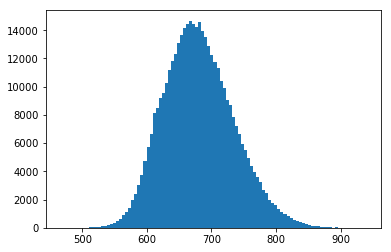

In [83]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy
bias = s.odds_score - s.double_odds*np.log(s.odds_X_to_one)/np.log(2)   
odds = s.double_odds/np.log(2)         
y_train_score = bias+odds*np.log(1/y_pred_train-1)  
plt.hist(y_train_score,bins=100)

In [84]:
for m in ["JAN-17",  "FEB-17",  "MAR-17",  "APR-17"] :
    print(m)
    print('GINI NEW:', 2*roc_auc_score(xs_train["FLG_MOB12_90"][xs_train["AGR_DATE"]==m],xs_train["y_pred"][xs_train["AGR_DATE"]==m])-1 )
    print('GINI OLD:', 2*roc_auc_score(xs_train["FLG_MOB12_90"][xs_train["AGR_DATE"]==m],-xs_train["SCORE_FINAL"][xs_train["AGR_DATE"]==m])-1 )
for m in ["MAY-17",  "JUN-17",  "JUL-17"] :
    print(m)
    print('GINI NEW:', 2*roc_auc_score(xs_test["FLG_MOB12_90"][xs_test["AGR_DATE"]==m],xs_test["y_pred"][xs_test["AGR_DATE"]==m])-1 )
    print('GINI OLD:', 2*roc_auc_score(xs_test["FLG_MOB12_90"][xs_test["AGR_DATE"]==m],-xs_test["SCORE_FINAL"][xs_test["AGR_DATE"]==m])-1 )


JAN-17
GINI NEW: 0.631051705906
GINI OLD: 0.536683812772
FEB-17
GINI NEW: 0.633763858555
GINI OLD: 0.536707647225
MAR-17
GINI NEW: 0.643389210051
GINI OLD: 0.545756825942
APR-17
GINI NEW: 0.658535840368
GINI OLD: 0.554292844462
MAY-17
GINI NEW: 0.650723775008
GINI OLD: 0.56239354986
JUN-17
GINI NEW: 0.637856869263
GINI OLD: 0.572177964849
JUL-17
GINI NEW: 0.631375192687
GINI OLD: 0.561097897185
